# Классификация спектров

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as tck

import ipywidgets as widgets

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import scale as std_scale, robust_scale
from sklearn.model_selection import StratifiedShuffleSplit

# from scipy.signal import find_peaks, find_peaks_cwt, peak_widths

import numpy as np
from sklearn.datasets import load_digits
from sklearn.preprocessing import scale
import sklearn.metrics as metrics

import matplotlib.pyplot as plt
import matplotlib.animation as ani

import mlgrad.models as models
import mlgrad.regr as regr
import mlgrad.plots as plots
import mlgrad.funcs as funcs
import mlgrad.funcs2 as funcs2
import mlgrad.loss as loss
import mlgrad.gd as gd
import mlgrad.smooth as smooth
import mlgrad.inventory as inventory
from mlgrad.inventory import modified_zscore as mzscore

import pybaselines

from mlgrad.boost.anyboost import AnyBoostClassification
import sys

In [2]:
def plot_spectra(d_191, d_606, ax=None):
    if ax is None:
        ax = plt.gca()
    for item_191, item_606 in zip(d_191, d_606):
        ax.plot(np.mean(item_191[2], axis=0), color='r', linewidth=0.75, label='191', alpha=0.5)
        ax.plot(np.mean(item_606[2], axis=0), color='b', linewidth=0.75, label='606', alpha=0.5)
    # ax.legend(loc="upper left")
    ax.set_xlabel("$k$ (индекс точки)")
    ax.set_ylabel("Интенсивность (нормированная)")
    ax.set_title("Спектры (усредненные) по классам и значения коэффициентов")
    ax.minorticks_on()

def plot_spectra2(XX, YY, ax=None):
    if ax is None:
        ax = plt.gca()
    XX1 = XX[YY == 1]
    XX2 = XX[YY == -1]
    ax.plot(np.mean(XX1, axis=0), color='r', linewidth=0.75, label='191', alpha=0.25)
    ax.plot(np.mean(XX2, axis=0), color='b', linewidth=0.75, label='191', alpha=0.25)
    
    # for item_191, item_606 in zip(d_191, d_606):
    #     ax.plot(np.mean(item_191[2], axis=0), color='r', linewidth=1.0, label='191', alpha=0.25)
    #     ax.plot(np.mean(item_606[2], axis=0), color='b', linewidth=1.0, label='606', alpha=0.25)
    # ax.legend(loc="upper left")
    ax.set_xlabel("$k$ (индекс точки)")
    ax.set_ylabel("Интенсивность (нормированная)")
    ax.set_title("Спектры (усредненные) по классам и значения коэффициентов")
    ax.minorticks_on()

def plot_params(param, ax=None):
    pp = np.asarray(param)
    pp = pp[1:]
    ymax = np.asarray(pp.copy())
    ymin = np.asarray(pp.copy())
    np.putmask(ymax, ymax<0, 0)
    np.putmask(ymin, ymax>0, 0)
    n = len(ymin)
    nz = (abs(pp) != 0).sum()
    plt.vlines(range(n), ymin, ymax, color='k', linewidth=1., label=f"кол-во коэфф. != 0 -> {nz}")
    plt.minorticks_on()
    plt.ylabel(r"$w_k$")
    # ax.legend(loc="upper right")


In [3]:
def load_data(fold):
    Xs = []
    Ys = []
    
    for fname in os.listdir(fold):
        if not fname.endswith(".txt"):
            continue
        xy = np.loadtxt(f"{fold}/{fname}", delimiter="\t")
        xy = xy[100:]
        xs = xy[:,0].reshape(-1)
        ys = xy[:,1].reshape(-1)
        ys -= ys.min()
        # ys /= np.trapz(ys, xs)
        # ys *= 1000
        Xs.append(xs)
        Ys.append(ys)
    Xs, Ys =  np.array(Xs), np.array(Ys)
    return Xs, Ys

In [4]:
def load_data_folder(root):
    d_191 = []
    d_606 = []
    fnames = []
    for f in os.scandir(root):
        if f.is_dir():
            if "3_4" in f.name or "3_5" in f.name:
                continue
            fnames.append(f.name)
    fnames.sort()
    for fname in fnames:
        print(fname)
        for sf in os.scandir(f"{root}/{fname}"):
            if sf.is_dir():
                print('\t', sf.name)
                Xs, Ys = load_data(f"{root}/{fname}/{sf.name}")
                if '191' in sf.name:
                    d_191.append((fname, Xs, Ys))
                elif '606' in sf.name:
                    d_606.append((fname, Xs, Ys))
    d_191.sort()
    d_606.sort()
    return d_191, d_606                

In [5]:
from mlgrad.outl import despike_whittaker

def preprocess_spectras(Xs, Ys):
    for k in range(len(Xs)):
        xs = Xs[k]
        ys = Ys[k]
        
        ys = despike_whittaker(ys, m=1, tau=2.5)
        ys = despike_whittaker(ys, m=1, tau=2.5)
        ys = despike_whittaker(ys, m=1, tau=2.5)
        ys = smooth.whittaker.whittaker_smooth(ys, tau2=1.0)
        ## ys = rampy.smooth(xs, ys, method="whittaker", Lambda=6.0)
        bs, _ = pybaselines.whittaker.aspls(ys, lam=1.0e4)
        
        # bs, _ = pybaselines.whittaker.arpls(ys, lam=1.0e5)
        # bs, _ = pybaselines.morphological.mor(ys)
        # bs, _ = pybaselines.morphological.mpls(ys, lam=1.0e6)
        
        ys = ys - bs

        # ys = smooth.whittaker(ys, tau2=4.0, tau1=0.0)

        ys -= ys.min()
        ys /= np.trapezoid(ys, xs)
        ys *= 1000
        # ys = rampy.smooth(xs, ys, method="whittaker", Lambda=4.0)
        Ys[k,:] = ys


def plot_spectras(name, V):
    fname = V[0]
    Xs = V[1]
    Ys = V[2]
    for k in range(len(Xs)):
        xs = Xs[k]
        ys = Ys[k]        
        # plt.plot(ys, color=color, linewidth=0.2, marker='s', markersize=2)
        if name == '191':
            color = 'r'
        elif name == '606':
            color = 'b'
        plt.plot(ys, color=color, linewidth=0.2, alpha=0.75) #, marker='s', markersize=1)

    plt.plot(np.median(Ys, axis=0), color='k', linewidth=1.5) #, marker='s', markersize=1)
    # plt.hlines(0, -30, 1000, linewidth=0.5, colors='k', linestyle='--')
    # plt.xlim(0, 200)
    plt.minorticks_on()
    plt.xlabel("Индекс (длины волны)")
    plt.ylabel("Интенсивность (нормированная)")
    plt.title(f"Класс: {name} | {fname}")
    plt.grid(1)


In [6]:
d_191, d_606 = load_data_folder("SAXXX")
print(len(d_191), len(d_606))

20231012_16_SA_191_606_6_4_(less30_more10)_532nm
	 SA_606_6_4_more10_less30
	 SA191_6_4_more10_less30
20231017_20_SA_191_606_6_5_(less30_more10)_532nm
	 SA_191_6_5_less30_ more10
	 SA_606_6_5_less30_ more10
20231113_27_SA_191_606_6_4_(less30_more10)_532nm
	 SA_191_6_4_less 30_more10
	 SA_606_6_4_less 30_more10
20231130_28_SA_191_606_6_5_(less30_more10)_repeat#2_532nm.rar
	 SA_191_6_4_less 30_more10
	 SA_606_6_4_less 30_more10
20240411_35_SA_606_191_6_4_(less30_more10)_Ag#G(01.03.24)_532nm_1
	 SA_191_6_4_(less30_more10)_
	 SA_606_6_4_(less30_more10)_
20240411_35_SA_606_191_6_5_(less30_more10)_Ag#G(01.03.24)_532nm_2
	 SA_191_6_5_(less30_more10)_
	 SA_606_6_5_(less30_more10)_
20240412_36_SA_606_191_6_4_6_5_(less30_more10)_Ag#G(01.03.24)_532nm
	 SA_606_6_5_(less30_more10)
	 SA_191_6_5_(less30_more10)
7 7


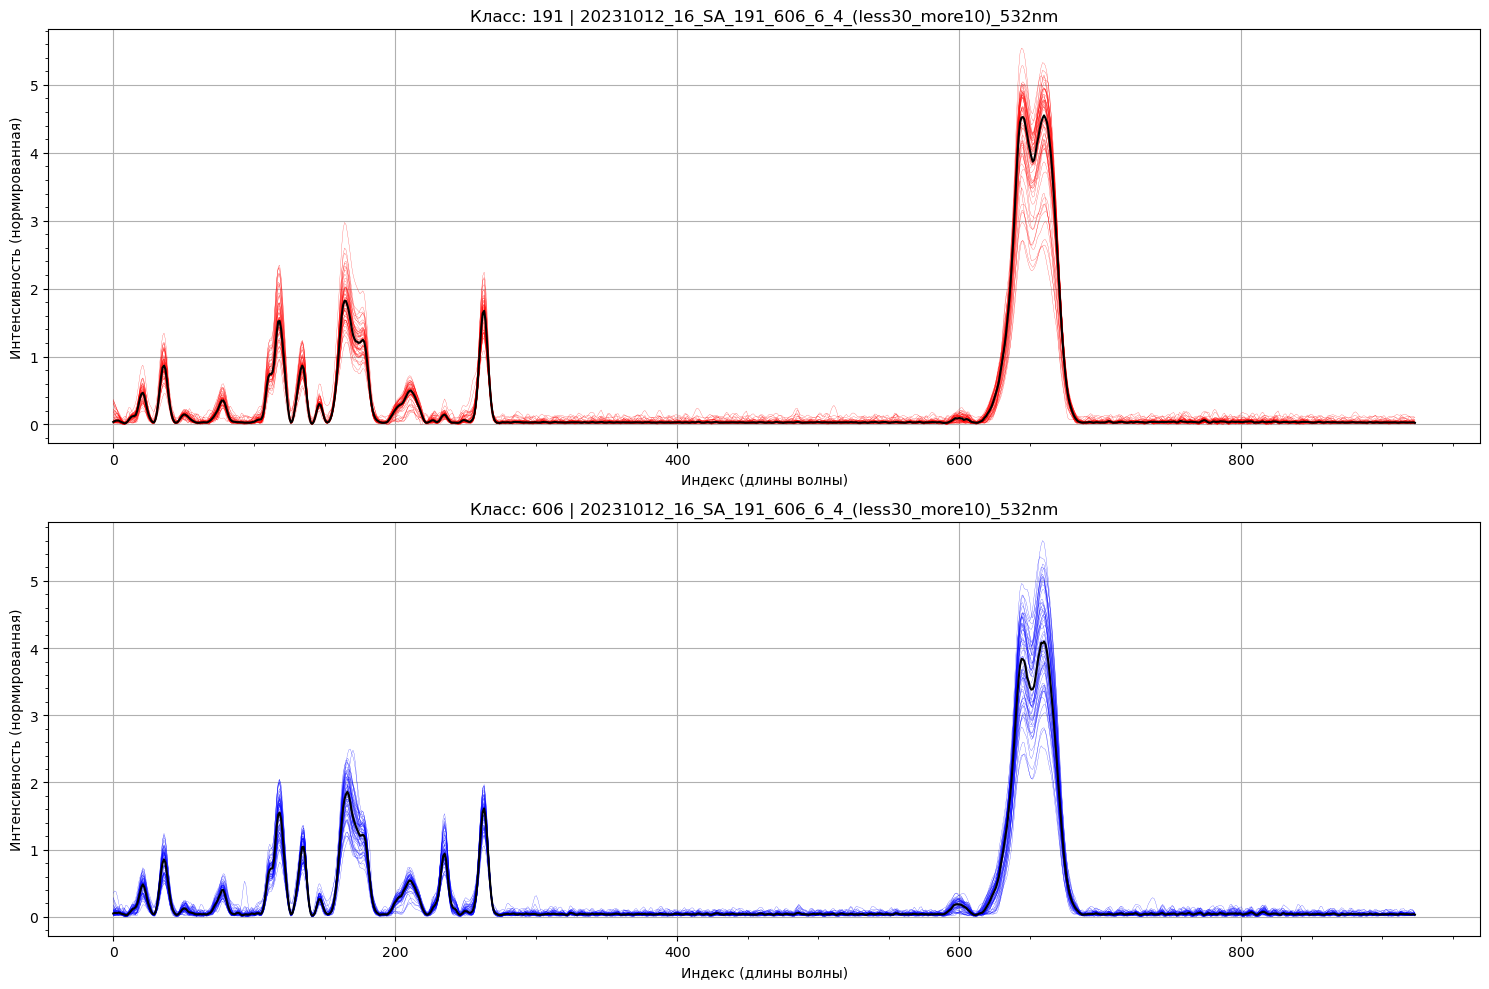

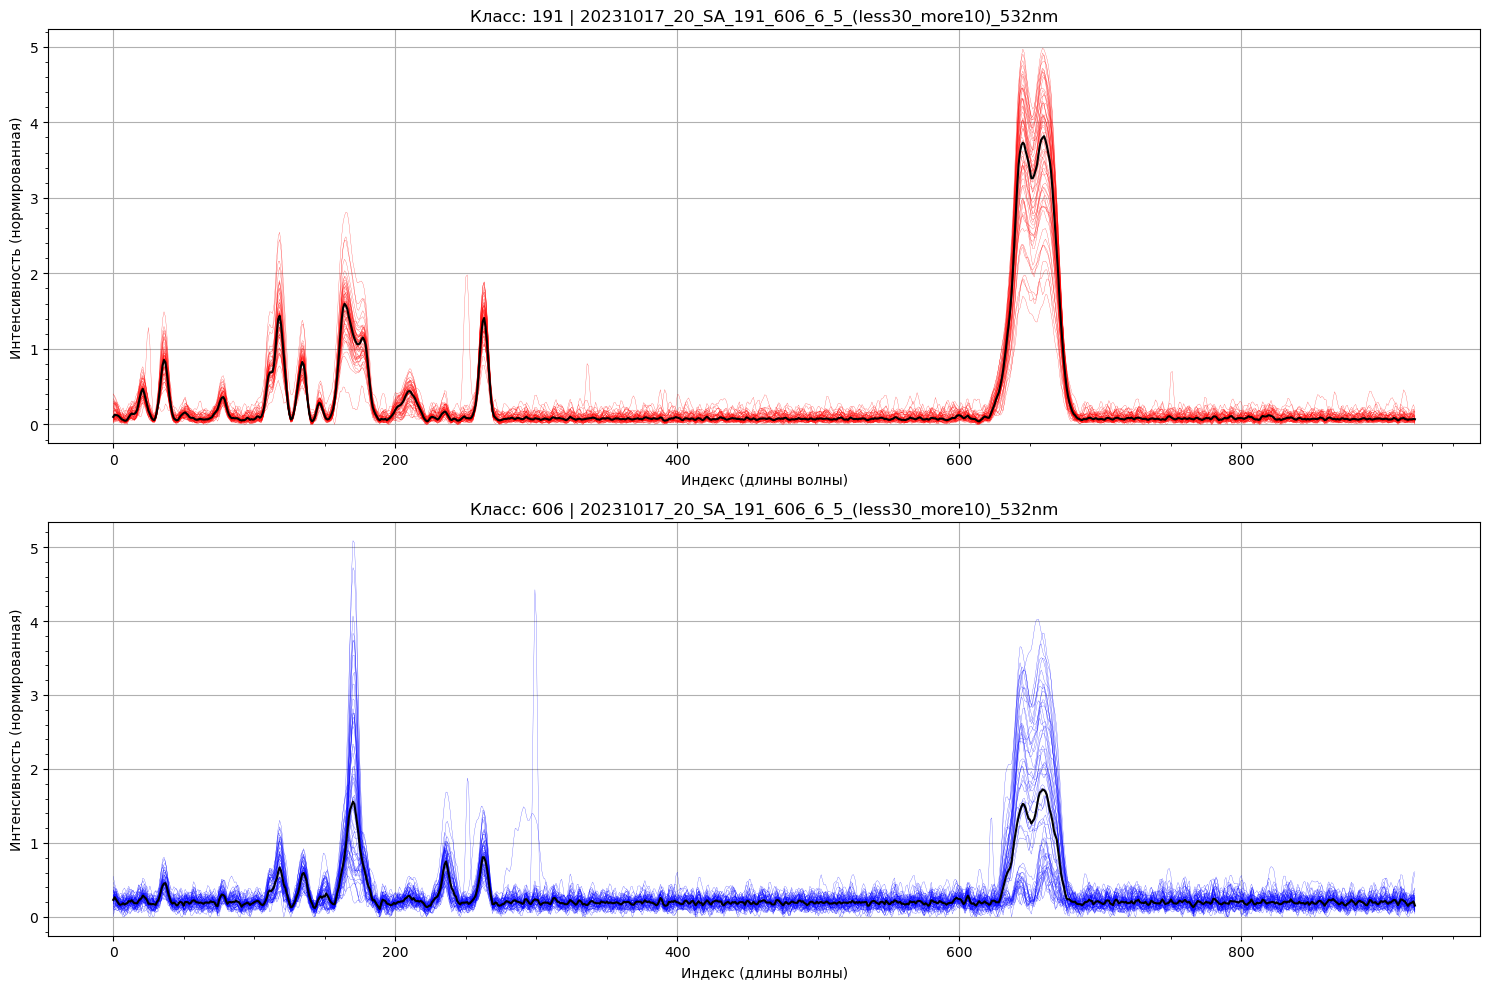

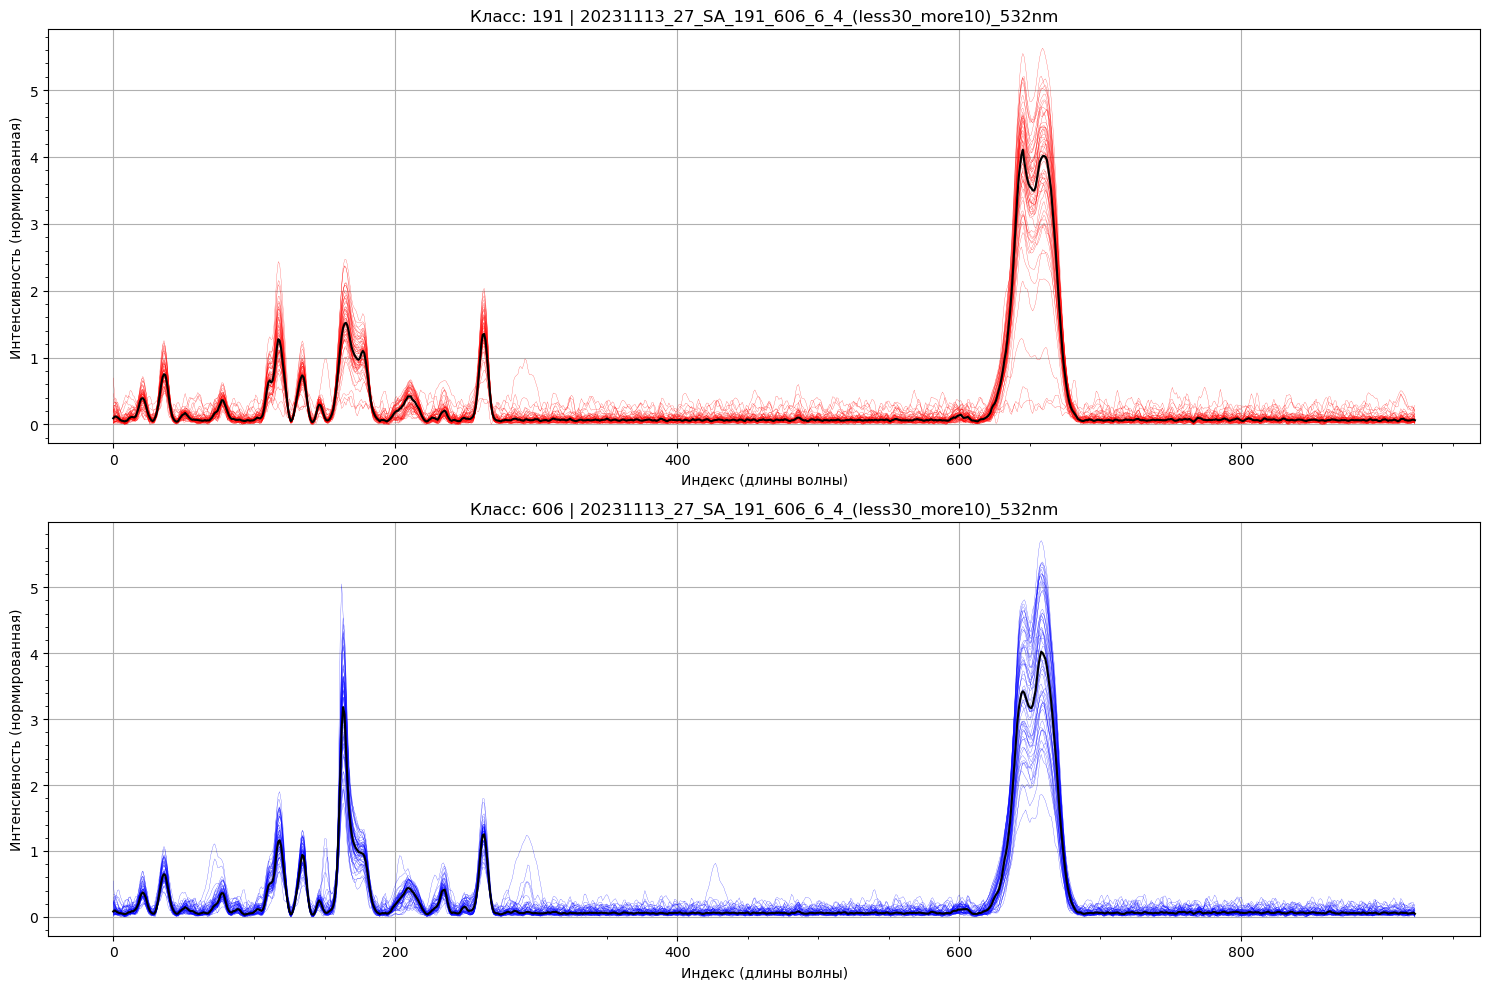

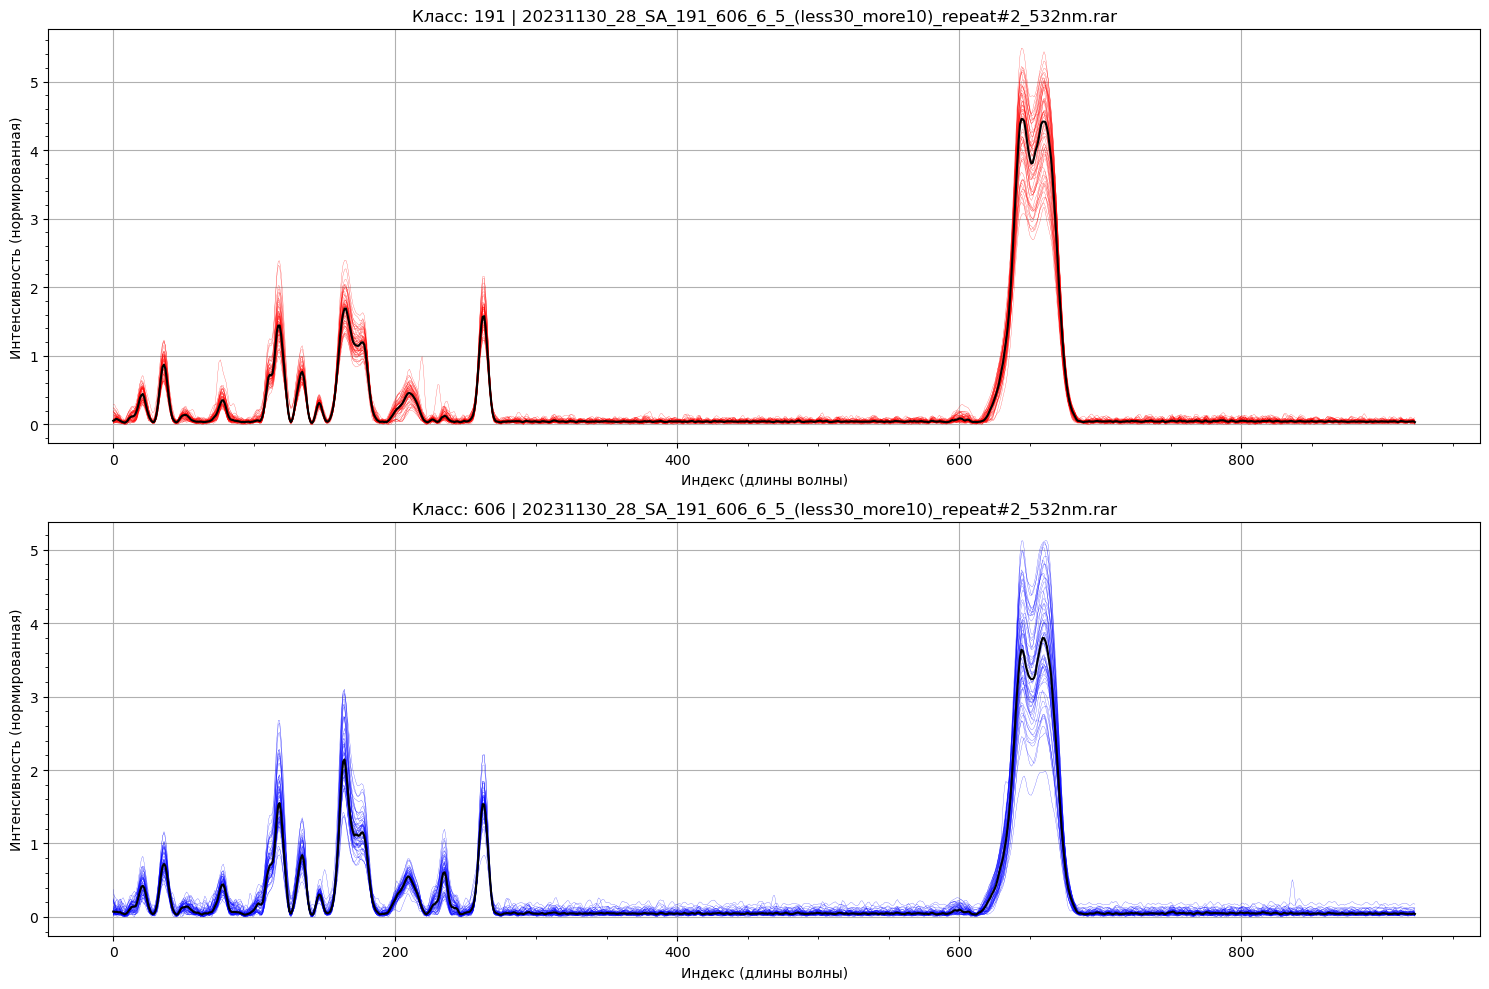

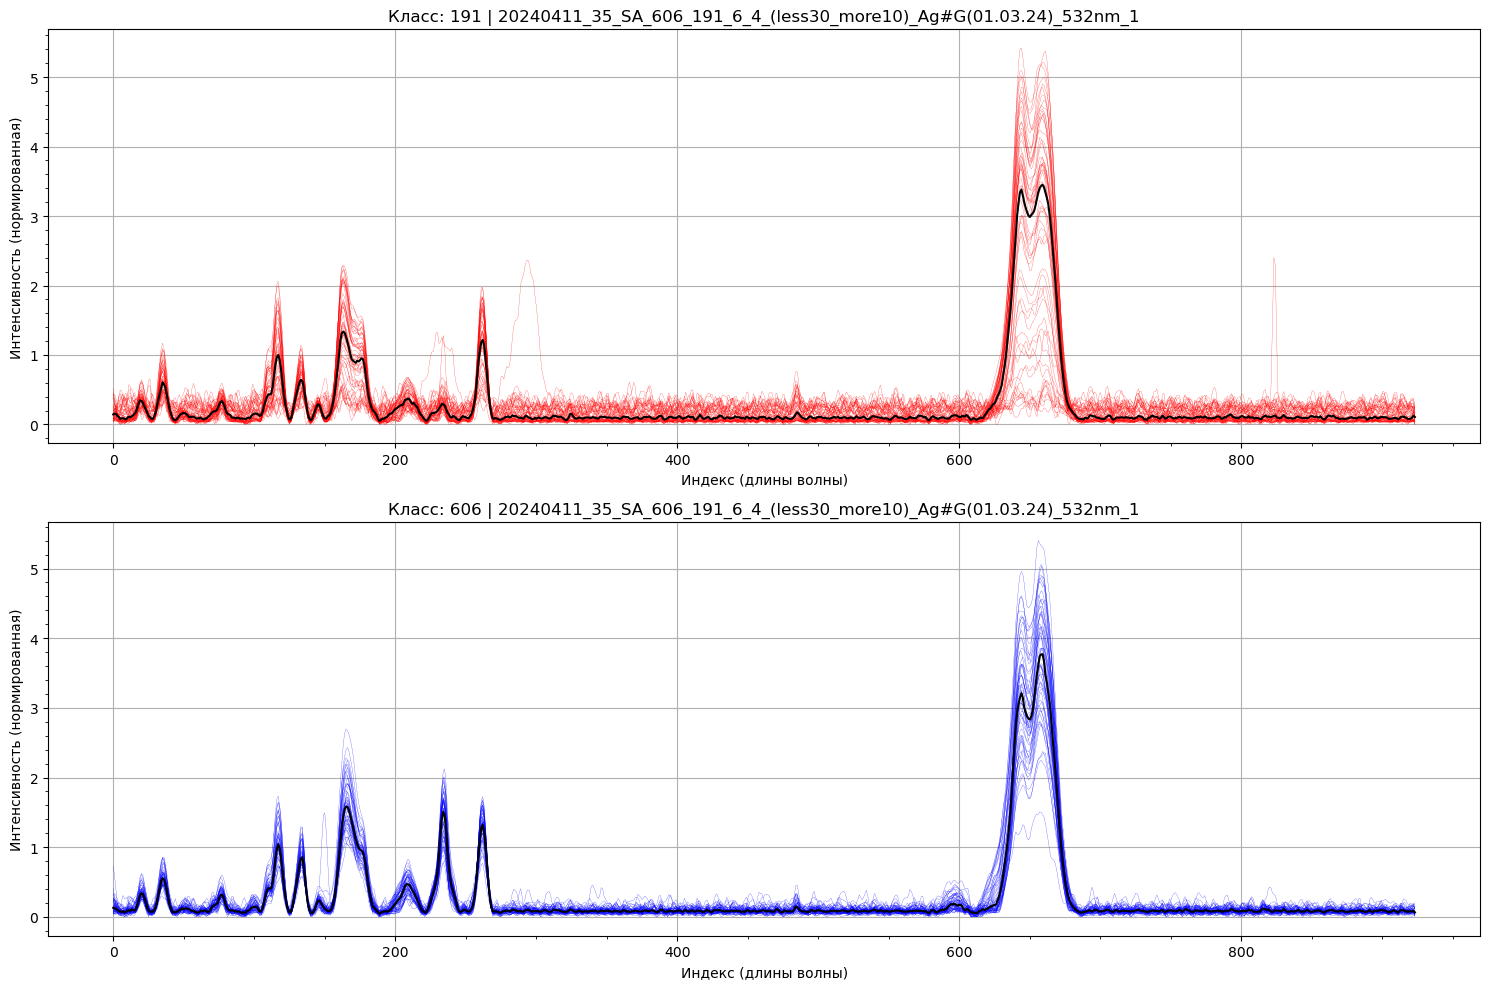

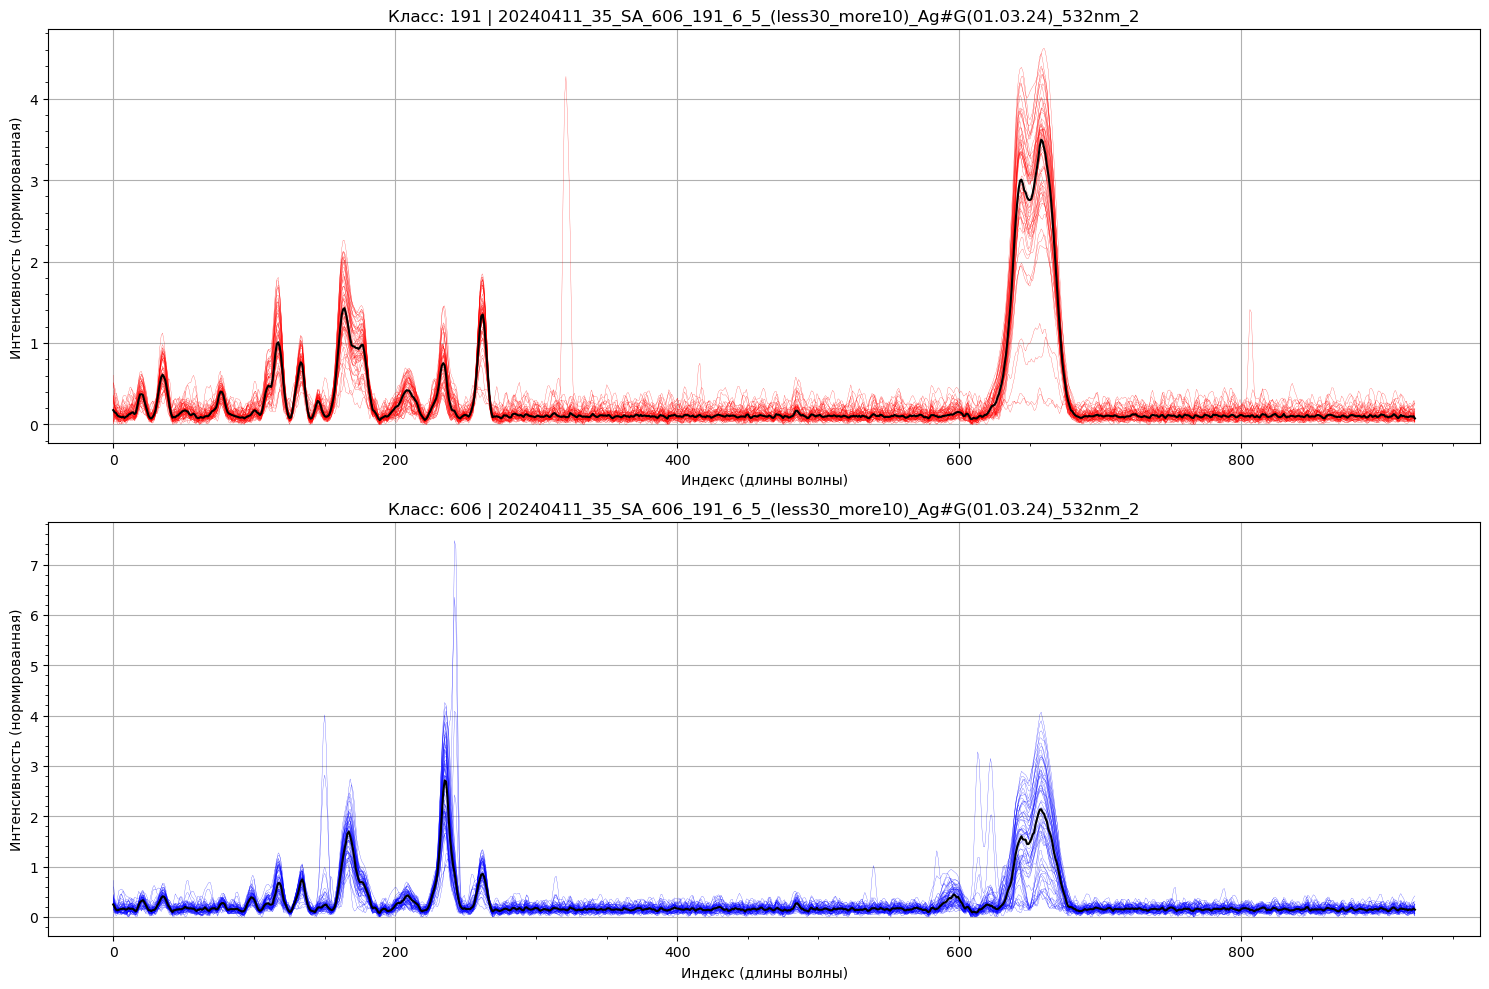

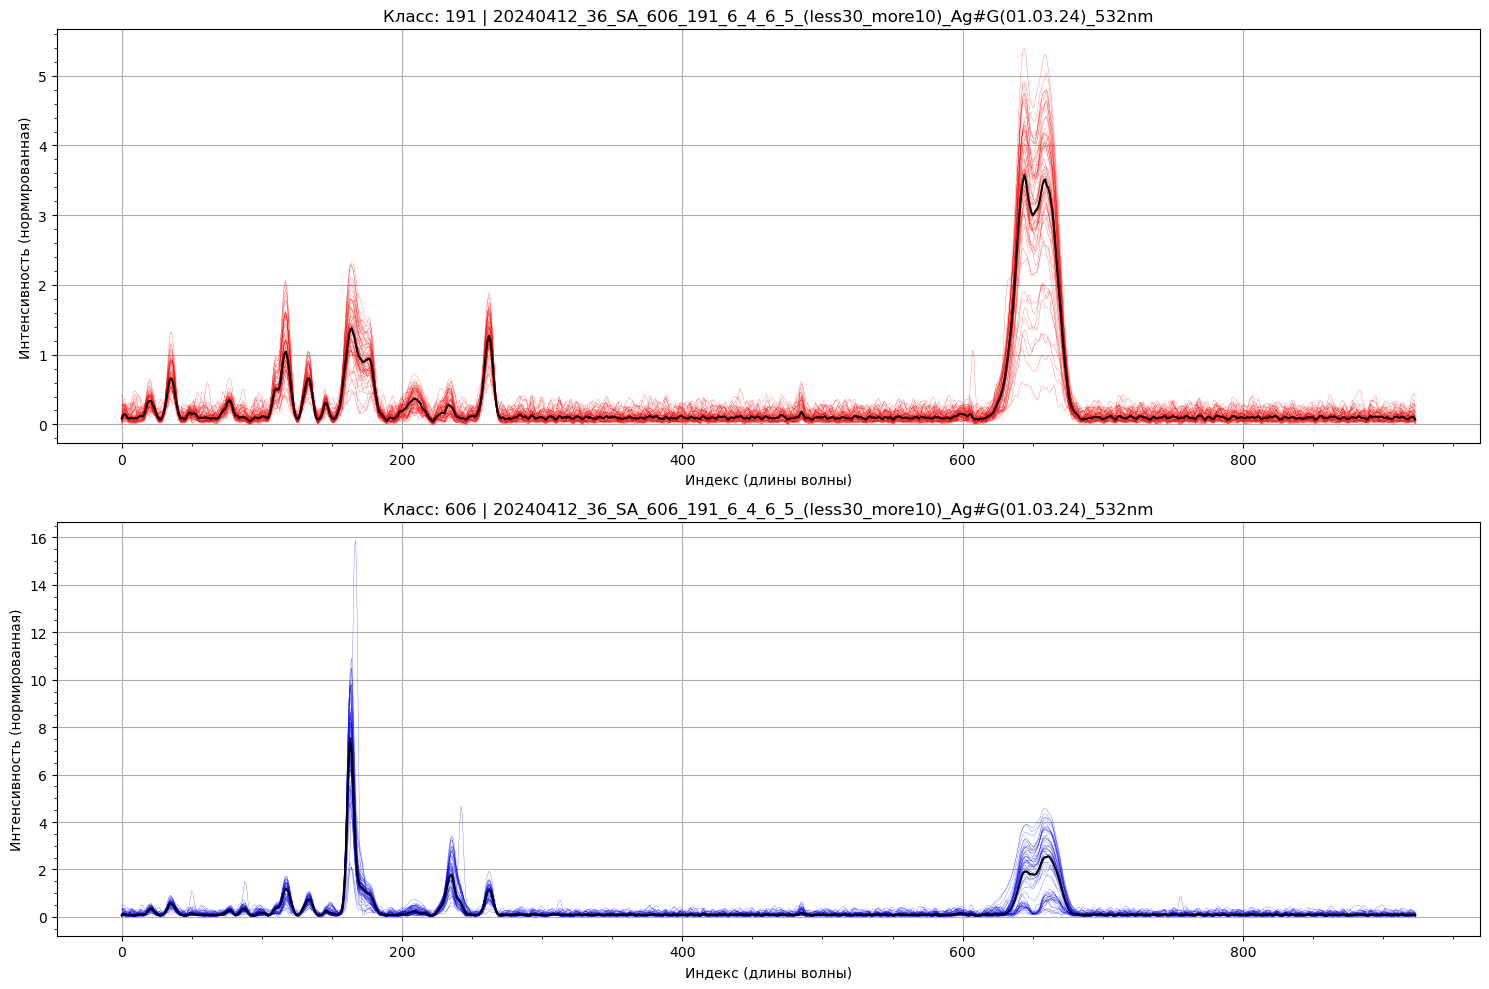

In [7]:
for v_191, v_606 in zip(d_191, d_606):
    plt.figure(figsize=(15,10))
    plt.subplot(2,1,1)
    preprocess_spectras(v_191[1], v_191[2])    
    plot_spectras('191', v_191)
    
    plt.subplot(2,1,2)
    preprocess_spectras(v_606[1], v_606[2])
    plot_spectras('606', v_606)
        
    plt.tight_layout()
    plt.show()


In [8]:
def concatenate_data(d, cls):
    YYs = []
    for _, _, Ys in d:
        YYs.append(Ys)
    YYs = tuple(YYs)
    XX = np.concatenate(YYs, axis=0)
    YY = np.full(len(XX), cls, 'd')
    return XX, YY

XX1, YY1 = concatenate_data(d_191, 1)
XX2, YY2 = concatenate_data(d_606, -1)
print(len(XX1), len(XX2))
XX = np.concatenate((XX1, XX2), axis=0)
YY = np.concatenate((YY1, YY2), axis=0)

N, n = XX.shape
print(f"Количество спектров: {N} Размерность вектора x: {n}")

421 422
Количество спектров: 843 Размерность вектора x: 924


In [9]:
# from sklearn.decomposition import PCA
# pca = PCA()
# pca.fit(XX)
# UU = pca.transform(XX)
# plt.scatter(UU[:,0], UU[:,1], c=YY)
# plt.show()
# # plt.figure(figsize=(15,15))
# # plt.bar(range(100), pca.explained_variance_[:100])
# # plt.minorticks_on()
# # plt.show()

In [10]:
hinge_loss = loss.MarginLoss(funcs.Hinge(1.0))
hinge_loss0 = loss.MarginLoss(funcs.Hinge(0.0))
softhinge_func = funcs.SoftHinge_Exp(10.0)
softhinge_loss = loss.MarginLoss(softhinge_func)
doom_loss = loss.MarginLoss(funcs.DOOM(1.0))
l2_reg = funcs2.SquareNorm(1)
l1_reg = funcs2.AbsoluteNorm(1)
l05_reg = funcs2.PowerNorm(0.9)
soft_l1_reg = funcs2.SoftAbsoluteNorm(0.000001)
sigmoidal_func = funcs.Sigmoidal(10.0)
sigmoidal_func2 = funcs.Sigmoidal(1.0)
sq_loss = loss.ErrorLoss(funcs.Square())

### Линейное разделение (функция Хинжа, без регуляризации)

$$
w^\star = \arg \min_{\mathbf{w}} 
\frac{1}{N}\sum_{k=1}^N 
H\bigl(y_k[w_0+(\mathbf{w},\mathbf{x}_k)]\bigr)
$$
$$
H(u) = \max(-u,0)
$$

In [ ]:
# # График функции Хинжа
# plt.figure(figsize=(6,3))
# plt.plot([-1,0,1],[1,0,0], linewidth=2, color='k')
# plt.title("Функция Хинжа")
# plt.hlines(0,-1,0, linestyles='dashed', color='LightGrey')
# plt.vlines(0,0,1, linestyles='dashed', color='LightGrey')
# plt.xlabel(r"$u$")
# plt.ylabel(r"$H(u)$")
# plt.show()

Относительное число правильных ответов: 0.9205219454329775


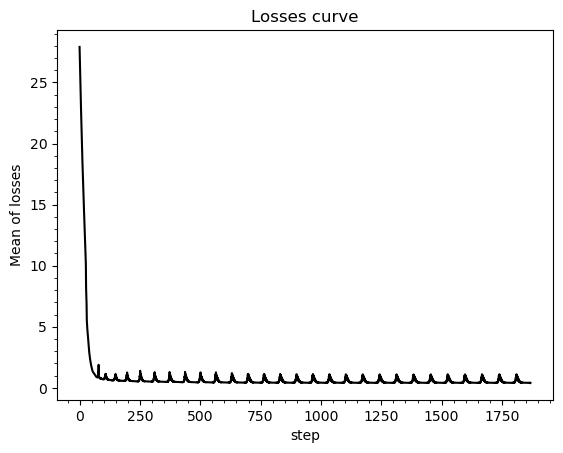

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


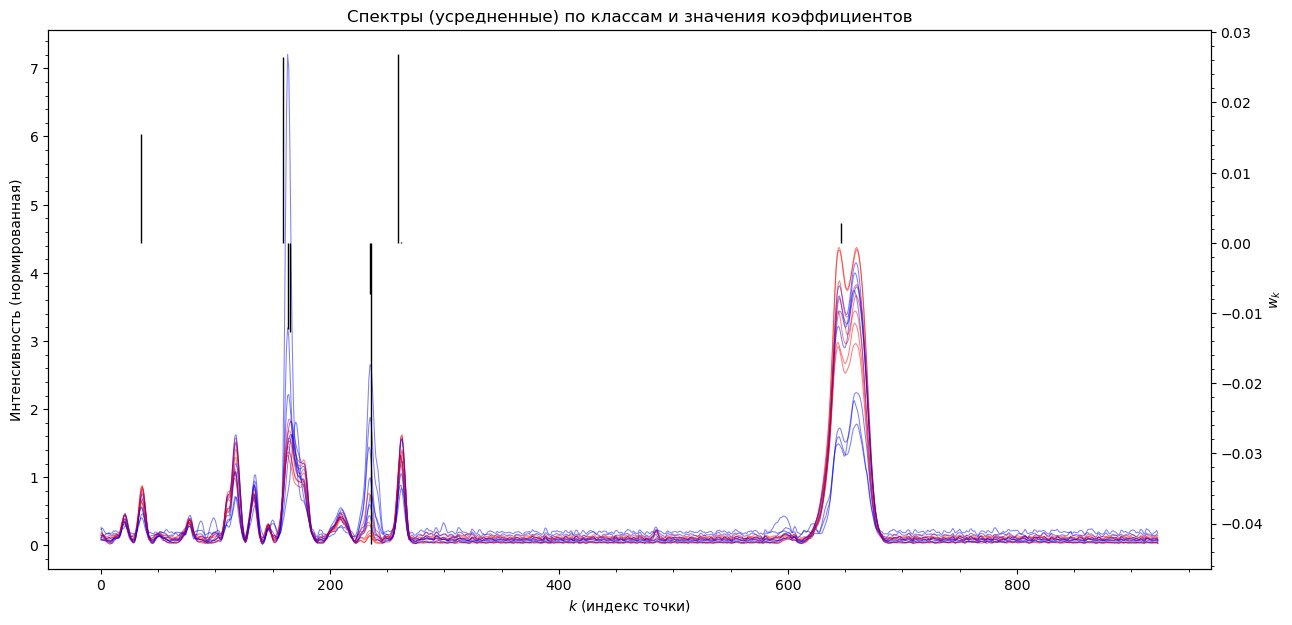

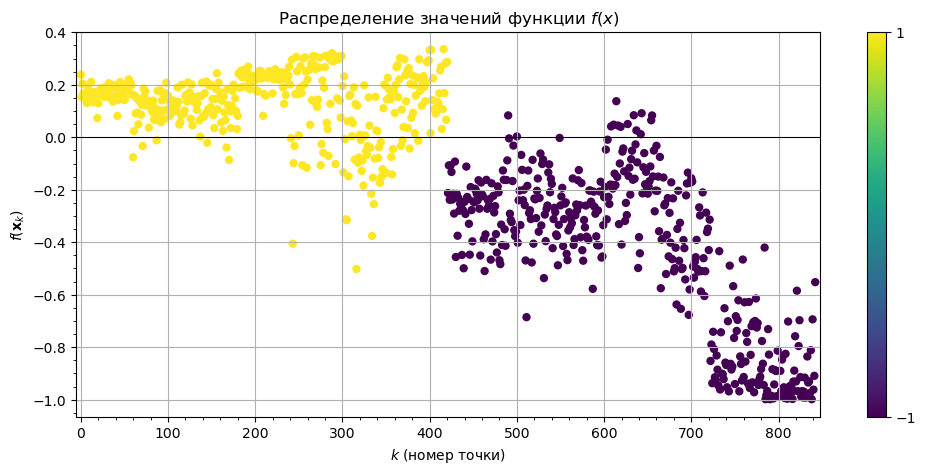

In [11]:
# mod1 = models.LinearModel(n) # линейная модель
mod1 = models.SigmaNeuronModel(sigmoidal_func, n)
alg1 = regr.regression(XX, YY, mod1, softhinge_loss,
                  regnorm=funcs2.AbsoluteNorm(), tau=1.0, 
                  normalizer=gd.Masked(mod1.n_param, 1.0e-4),
                  h=0.001, n_iter=3000, tol=1.0e-5)
# inventory.normalize2(mod1.param)
print("Относительное число правильных ответов:", 
        metrics.accuracy_score(YY, np.sign(mod1.evaluate_all(XX))))

plots.plot_losses(alg1)
plt.show()

plt.figure(figsize=(15,7))
ax1 = plt.gca()
plot_spectra(d_191, d_606, ax=ax1)
ax2 = plt.twinx(ax1)
plot_params(mod1.param, ax=ax2)
plt.savefig("fig/spectra_l1_3.eps")
plt.show()

plt.figure(figsize=(12,5))
plots.plot_cls_function(mod1, XX, YY)
plt.show()
# plot_params(mod1.param)
# plt.show()WS

### Проекция на главные классифицирующие компоненты

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


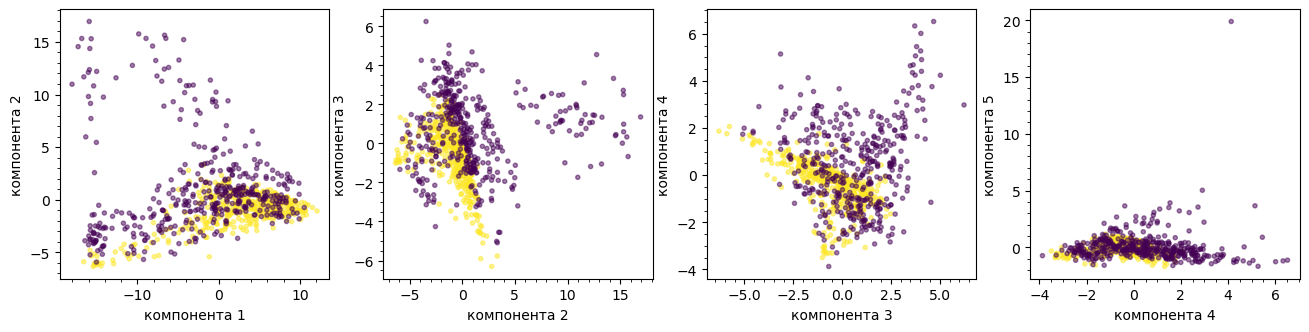

In [11]:
from sklearn.decomposition import PCA
pca = PCA(5)
UU = pca.fit_transform(XX)
plt.figure(figsize=(16,3.5))
plt.subplot(1,4,1)
plt.scatter(UU[:,0], UU[:,1], c=YY, s=9, alpha=0.5)
plt.xlabel("компонента 1")
plt.ylabel("компонента 2")
plt.minorticks_on()
plt.subplot(1,4,2)
plt.scatter(UU[:,1], UU[:,2], c=YY, s=9, alpha=0.5)
plt.xlabel("компонента 2")
plt.ylabel("компонента 3")
plt.minorticks_on()
plt.subplot(1,4,3)
plt.scatter(UU[:,2], UU[:,3], c=YY, s=9, alpha=0.5)
plt.xlabel("компонента 3")
plt.ylabel("компонента 4")
plt.minorticks_on()
plt.subplot(1,4,4)
plt.scatter(UU[:,3], UU[:,4], c=YY, s=9, alpha=0.5)
plt.xlabel("компонента 4")
plt.ylabel("компонента 5")
plt.minorticks_on()
plt.savefig("fig/pca_1.eps")
plt.show()

In [12]:
def make_model(n):
    mod = models.LinearModel(n)
    return mod

def cls_pca2(X, Y, lossfunc, m=2, model_maker=make_model, 
             regnorm=None, tau=0.0,
             verbose=True, visual=True):
    As = []
    Us = []
    mods = []
    XX, YY = X, Y
    n = XX.shape[1]
    
    for i in range(m):
        mod = model_maker(n)
        # mod.use_regularizer(regnorm, tau)
        alg = regr.regression(XX, YY, mod, lossfunc,
                  normalizer=gd.Masked(mod.n_param, 1.0e-4),
                  regnorm=regnorm, tau=tau,
                  h=0.002, n_iter=5000, tol=1.0e-7)

        # plt.figure(figsize=(12,3))
        # plots.plot_losses(alg)
        # plt.show()
            
        a = np.array(mod.param, copy=True)
        a1 = a[1:]
        for aa in As:
            aa1 = aa[1:]
            a1 -= (aa1 @ a1) * aa1
        a /= np.sqrt(a1 @ a1)
        mod.param[:] = a
        As.append(a)

        U = mod.evaluate(XX)
        score = metrics.accuracy_score(np.sign(U), YY)
        if score < 0.5:
            a[:] = -a
            mod.param[:] = a
            U = mod.evaluate(XX)
        Us.append(U)
        mods.append(mod)
        
        if verbose:
            print(metrics.accuracy_score(np.sign(U), YY))
            if visual:
                plt.figure(figsize=(15,3))
                ax1 = plt.gca()
                plot_spectra2(XX, YY, ax=ax1)
                ax2 = plt.twinx(ax1)
                plot_params(mod.param, ax=ax2)
                plt.legend()
                plt.show()

        c = a[0]
        XX = np.array([(xx - (xx @ a1 + c) * a1) for xx in XX])

    As = np.array(As)
    Us = np.array(Us)
        
    return As, Us, mods

0.9157769869513642


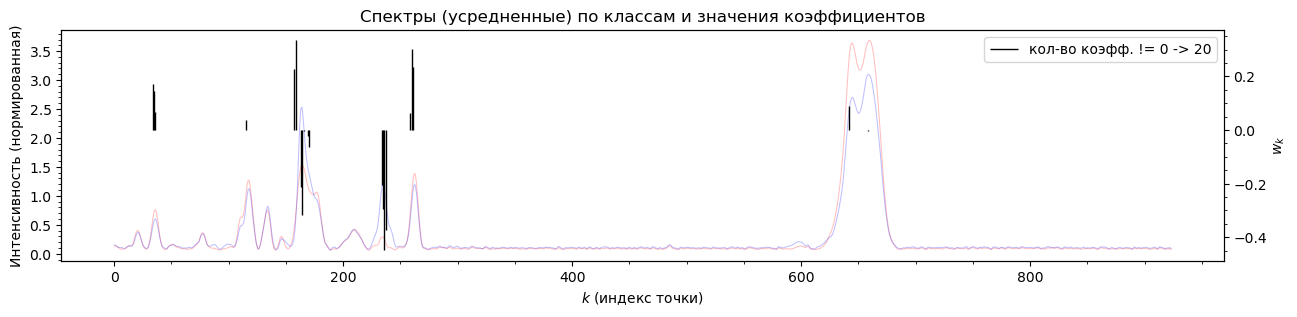

0.9252669039145908


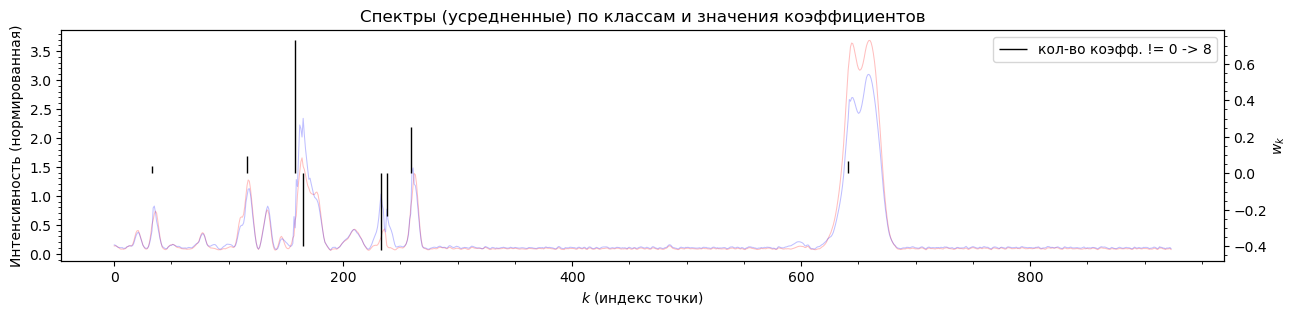

0.9086595492289442


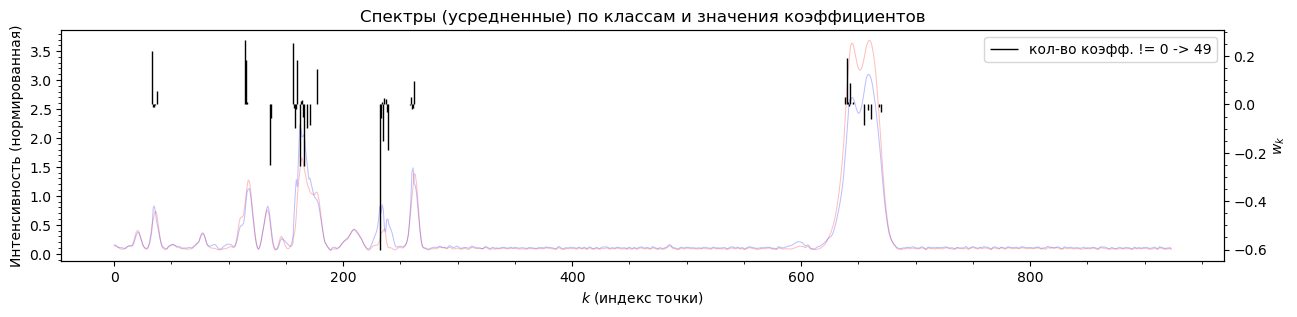

0.701067615658363


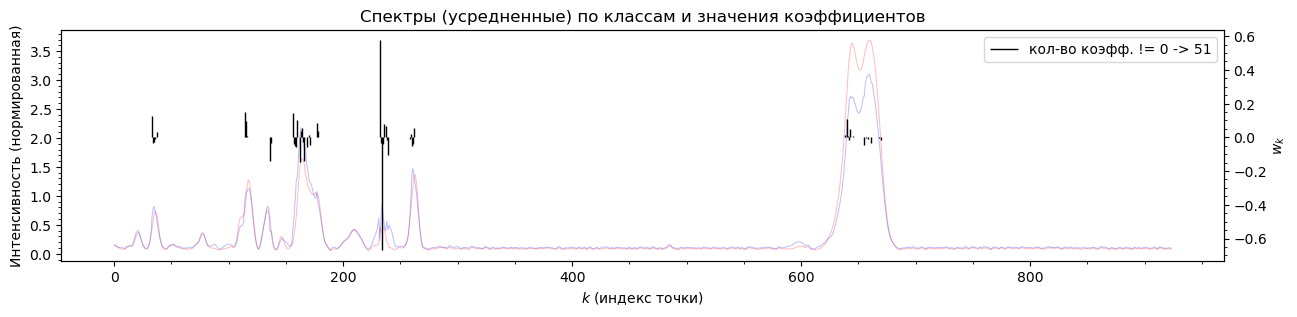

0.8457888493475683


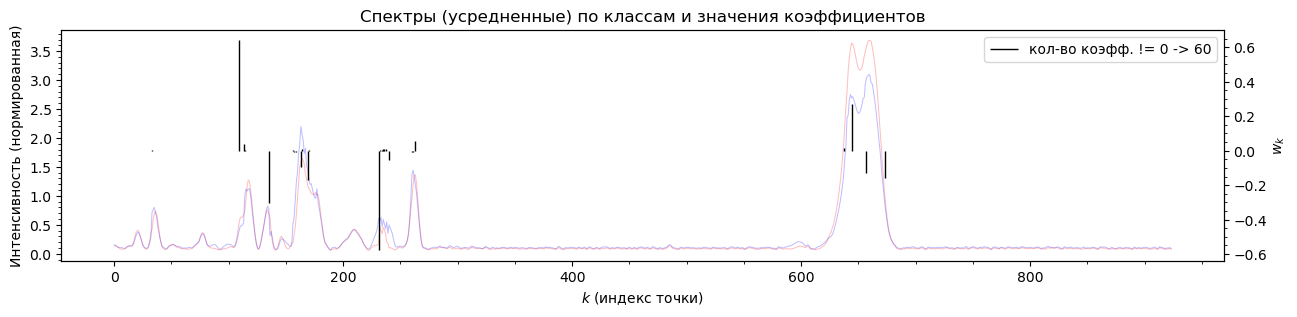

In [13]:
As, Us, mods = cls_pca2(XX, YY, softhinge_loss, m=5, regnorm=l1_reg, tau=0.1, visual=True)

# Us = [np.tanh(5*U) for U in Us]

# np.set_printoptions()
# with np.printoptions(precision=3, suppress=True):
#     print(As[:,1:] @ As[:,1:].T)


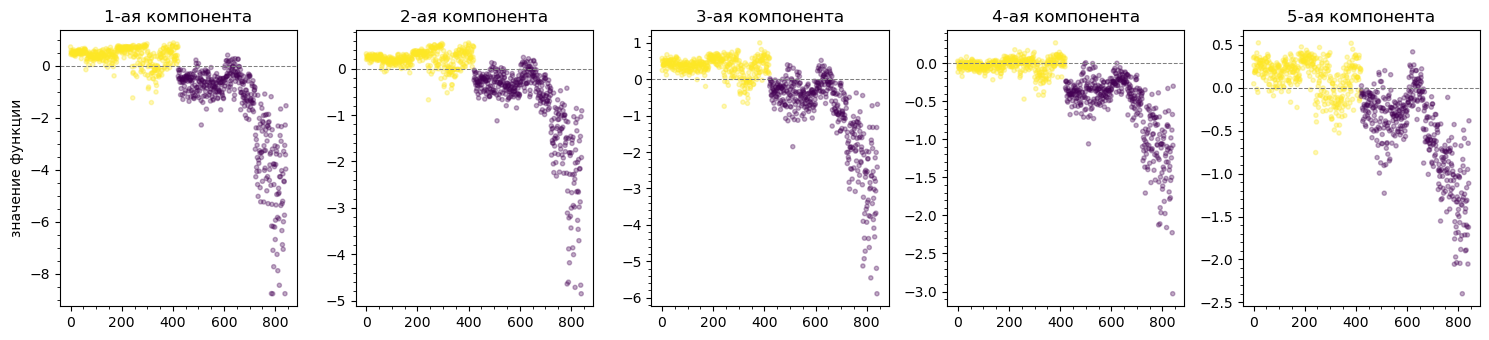

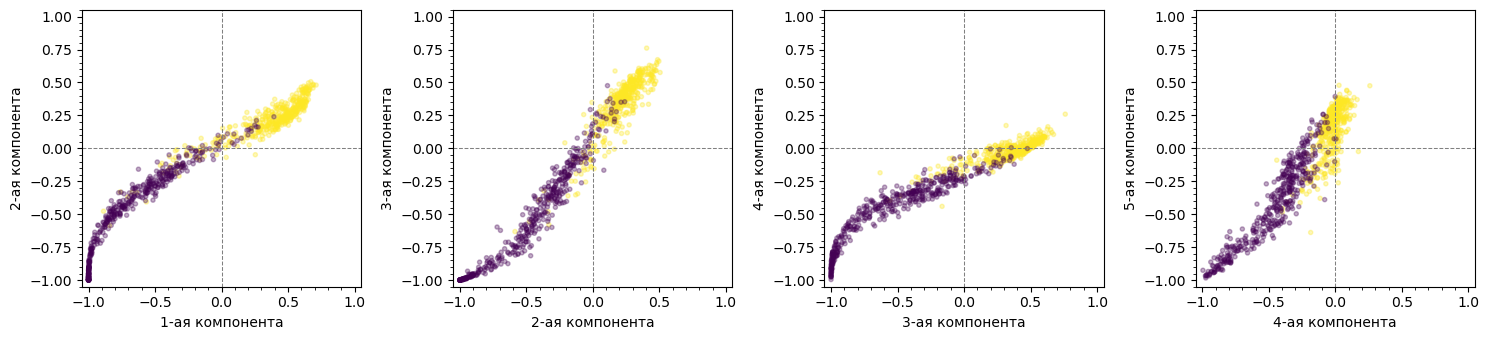

In [15]:
Us1 = [np.tanh(U) for U in Us]

plt.figure(figsize=(15,3.5))
m = 0
for i in range(5):
    plt.subplot(1,5,m+1)
    plt.title(f"{m+1}-ая компонента")
    plt.scatter(range(Us[m].shape[0]), Us[m], c=YY, s=9, alpha=0.33)
    plt.axline((0,0), (len(Us[m]),0), color='gray', ls='--', linewidth=0.75)
    # plt.xlabel("индекс точки")\
    if i == 0:
        plt.ylabel(f"значение функции")
    plt.minorticks_on()
    m += 1
plt.tight_layout()
# plt.savefig("fig/pca_cls_p1-3.eps")
plt.show()

plt.figure(figsize=(15,3.5))
m = 0
for i in range(4):
    plt.subplot(1,4,m+1)
    plt.scatter(Us1[m], Us1[m+1], c=YY, s=9, alpha=0.33)
    plt.xlabel(f"{m+1}-ая компонента")
    plt.ylabel(f"{m+2}-ая компонента")
    plt.ylim(-1.05,1.05)
    plt.xlim(-1.05,1.05)
    plt.axline((-1,0), (1,0), color='gray', ls='--', linewidth=0.75)
    plt.axline((0,-1), (0,1), color='gray', ls='--', linewidth=0.75)
    plt.minorticks_on()
    m += 1
plt.tight_layout()
# plt.savefig("fig/pca_cls_p1-3.eps")
plt.show()

### Линейное разделение (функция Хинжа, L2 регуляризация)

$$
w^\star = \arg \min_{\mathbf{w}} \frac{1}{N} \sum_{k=1}^N 
H\bigl(y_k[w_0+(\mathbf{w},\mathbf{x}_k)]\bigr) + \tau\|\mathbf{w}\|_2^2,
$$
$$
H(u) = \max(-u,0)
$$
$$
\|\mathbf{w}\|_2^2 = w_1^2+\cdots+w_n^2
$$

In [ ]:
tau_range = widgets.FloatSlider(0.01, min=0, max=10.0, step=0.01)
tau_range.layout.width="50%"
@widgets.interact(tau=tau_range)
def sigmaneuron_regularized(tau):
    mod = models.SigmaNeuronModel(sigmoidal_func, n)
    alg = regr.regression(XX, YY, mod, softhinge_loss, 
                     regnorm=funcs2.AbsoluteNorm(), tau=tau, 
                     normalizer=gd.Masked(mod.n_param, 1.0e-5),
                     h=0.001, tol=1.0e-4)
    print(f"tau: {tau:.2f} K: {alg.K}", end='  ')
    
    print("accuracy: {:.2f} {:.2f}".format( 
            metrics.accuracy_score(YY1, np.sign(mod.evaluate_all(XX1))),
            metrics.accuracy_score(YY2, np.sign(mod.evaluate_all(XX2)))))

    plt.figure(figsize=(15,4))
    ax1 = plt.gca()
    plot_spectra(d_191, d_606, ax=ax1)
    ax2 = plt.twinx(ax1)
    plot_params(mod.param[1:], ax=ax2)
    yy = np.abs(mod.param[1:]).max()
    ax2.set_ylim(-yy, yy)
    plt.show()
    
    plt.figure(figsize=(12,3))
    plots.plot_cls_function(mod, XX, YY)
    plt.show()
    
    plt.figure(figsize=(12,3))
    plots.plot_losses(alg)
    plt.show()    

In [ ]:
# plots.plot_hist_and_rank_distribution(abs(mzscore(YY*mod.evaluate(XX))), levels=[3.5])

### AnyBoost of SigmaNeuron with L1

In [ ]:
def model_factory1(n):
    mod = models.SigmaNeuronModel(sigmoidal_func, n)
    # mod.use_regularizer(l1_reg, 5.0)
    return mod

tau_range = widgets.FloatSlider(0.1, min=0, max=5.0, step=0.1)
tau_range.layout.width="50%"
@widgets.interact(tau=tau_range, continuous_update=False)
def anyboost_sn_l2(tau):
    tau_i = int(100*tau)
    ab = AnyBoostClassification(
            func=softhinge_func,
            lossfunc=softhinge_loss,
            model_factory=model_factory1, shrink=1.0, shrink_model=False,
            normalizer=gd.Masked(n+1, 1.0e-5),
            n_classifier=20,
            )
    ab.fit(XX, YY, h=0.001, tol=1.0e-4, regnorm=l1_reg, tau=tau, n_iter=1000)
    
    M = len(ab.H.models)
    G = np.zeros((M,n+1))
    plt.figure(figsize=(15,6))
    plt.title("tau:%.2f accuracy: %.2f %.2f" % ( 
            tau,
            metrics.accuracy_score(YY1, np.sign(ab.H.evaluate_all(XX1))),
            metrics.accuracy_score(YY2, np.sign(ab.H.evaluate_all(XX2)))))
    for j, mod in enumerate(ab.H.models[:M]):
        G[j,:] = mod.param
    g_max, g_min = G.max(), G.min()
    if g_max > 0 and g_min < 0:
        gg_max = max(g_max, abs(g_min))
        for gg in G:
            for i, g in enumerate(gg):
                if g > 0 and g_max < gg_max:
                   gg[i] *= gg_max / g_max 
                elif g < 0 and abs(g_min) < gg_max:
                   gg[i] *= gg_max / abs(g_min )
    cs=plt.imshow(G, aspect="auto", cmap=plt.cm.bwr, origin="lower")
    for i in range(1,len(ab.H)+1):
        plt.hlines(-0.5 + i, 0, n, colors='gray', linewidths=0.5, linestyles='--', alpha=0.5)
    plt.colorbar(cs)
    plt.tight_layout()
    plt.savefig(f"fig/anyboost_l1_{tau_i}.eps")
    plt.show()    
    
    plt.figure(figsize=(10,4))
    plots.plot_cls_function(ab.H, XX, YY)
    plt.grid(1)
    plt.show()

    plt.figure(figsize=(12,3))
    plt.title("Weak classifier weights")
    plt.bar(range(len(ab.H.weights)), ab.H.weights)
    plt.minorticks_on()
    plt.grid(1)
    plt.show()
    
    plt.figure(figsize=(12,3))
    plt.title("Losses")
    plt.plot(ab.lvals)
    plt.minorticks_on()
    plt.grid(1)
    plt.show()    
    plt.figure(figsize=(12,3))
    plt.title("Error")
    plt.plot(ab.errvals)
    plt.minorticks_on()
    plt.grid(1)
    plt.show()    

    # plt.figure(figsize=(12,3))
    # plt.title("Errors of weak classifiers")
    # plt.plot(ab.werrvals)
    # plt.minorticks_on()
    # plt.grid(1)
    # plt.show()    


In [ ]:
plt.figure(figsize=(12,3))
plt.title("Weak classifier margins")
plt.bar(range(len(ab.H.models)), ab.wlvals)
plt.minorticks_on()
plt.show()

In [ ]:
scores = np.array([metrics.accuracy_score(np.sign(mod.evaluate(XX)),YY) for mod in ab.H.models])
# print((scores>0.5).sum(), (scores<0.5).sum())
plt.hlines()

In [ ]:
plt.figure(figsize=(12,3))
plt.title(f"Weak classifiers accuracy scores (>0.5: {(scores>0.5).sum()}; <0.5: {(scores<0.5).sum()})")
plt.vlines(range(len(scores)), 0, scores)
plt.hlines(0.5, 0, len(scores), colors='grey', linestyles='--')
plt.minorticks_on()
plt.show()

In [ ]:
M = len(ab.H.models)
G = np.zeros((M,n+1))
plt.figure(figsize=(7,6))
for j, mod in enumerate(ab.H.models[:M]):
    G[j,:] = mod.param
cs=plt.imshow(G, aspect="auto", cmap=plt.cm.bwr)
plt.colorbar(cs)
plt.tight_layout()
plt.show()

### Нейронная сеть

In [ ]:
# tau1_range = widgets.FloatSlider(0.0, min=0.0, max=1.0, step=0.01)
# tau1_range.layout.width="50%"
tau2_range = widgets.FloatSlider(0.01, min=0.0, max=1.0, step=0.01)
tau2_range.layout.width="50%"
@widgets.interact(tau2=tau2_range)
def nn_l1_l1(tau2):
    n_hidden = 20
    head = models.LinearModel(n_hidden)
    # head.use_regularizer(l1_reg, tau2)
    body = models.FFNetworkModel()
    linear_layer = models.LinearLayer(n, n_hidden)
    linear_layer.use_regularizer(l1_reg, tau2)
    body.add(linear_layer)
    scale_layer = models.ScaleLayer(sigmoidal_func, n_hidden)
    body.add(scale_layer)
    nn = models.FFNetworkFuncModel(head, body)
    nn.allocate()
    nn.init_param()
    alg = regr.regression(XX, YY, nn, softhinge_loss, 
                     normalizer=gd.Masked(nn.n_param, 1.0e-4),
                     h=0.001, n_restart=1, tol=1.0e-4)

    # for i in range(1,n_hidden+1):
    #     if nn.head.param[i] == 0:
    #         nn.body.layers[0].matrix[i,:] = 0
    #     elif np.sum(nn.body.layers[0].matrix[i,:] == 0) == 0:
    #         nn.head.param[i] = 0
    
    plt.figure(figsize=(15,3))
    plots.plot_cls_function(nn, XX, YY)
    plt.show()

    plt.figure(figsize=(15,4))
    plt.subplot(2,1,1)
    plt.title("tau:%.2f accuracy: %.2f %.2f" % (
            tau2,
            metrics.accuracy_score(YY1, np.sign(nn.evaluate(XX1))),
            metrics.accuracy_score(YY2, np.sign(nn.evaluate(XX2)))))
    
    plot_params(head.param)
    plt.minorticks_on()
    plt.subplot(2,1,2)
    plot_params(linear_layer.param)
    plt.minorticks_on()
    plt.tight_layout()
    plt.show()
        
    plt.figure(figsize=(15,3))
    plt.title("Losses")
    plt.plot(alg.lvals)
    plt.minorticks_on()
    plt.savefig(f"fig/nn_l1_{int(100*tau2)}.eps")
    plt.show()    


## Линейное разделение (сигмоидальная функция)

$$
y = \sigma\bigl(w_0 + (\mathbf{w},\mathbf{x})\bigr)
$$
где
$$
\sigma(s) = \mathrm{th}(s) = \frac{e^{\alpha x} - e^{-\alpha x}}{e^{\alpha x} + e^{-\alpha x}}
$$

$$
w^\star = \arg \min_{\mathbf{w}} \frac{1}{N} \sum_{k=1}^N 
\bigl(\sigma(w_0+(\mathbf{w},\mathbf{x}_k)) - y_k\bigr)^2 
$$


In [ ]:
mod1_s = models.SigmaNeuronModel(sigmoidal_func2, n)

In [ ]:
alg1_s = cls.classification_as_regr(XX, YY, mod1_s,
                                 lossfunc=sq_loss,
                                 normalizer=gd.Masked(mod1_s.n_param, 1.0e-4),
                                 h=0.002, n_iter=5000)
plt.figure(figsize=(12,3))
plt.plot(alg1_s.lvals)
plt.show()

print("Относительное число правильных ответов:", 
        metrics.accuracy_score(YY1, np.sign(mod1_s.evaluate_all(XX1))),
        metrics.accuracy_score(YY2, np.sign(mod1_s.evaluate_all(XX2))))

In [ ]:
plt.figure(figsize=(12,5))
plots.plot_cls_function(mod1_s, XX, YY)
plt.show()

In [ ]:
plt.figure(figsize=(15,8))
ax1 = plt.gca()
plot_spectra(d_191, d_606, ax=ax1)
ax2 = plt.twinx(ax1)
plot_params(mod1_s.param, ax=ax2)
plt.show()

### Линейное разделение (максимизация отступа, с L2 регуляризацией)

$$
w^\star = \arg \min_{\mathbf{w}} \frac{1}{N} \sum_{k=1}^N 
\bigl(\sigma(w_0+(\mathbf{w},\mathbf{x}_k)) - y_k\bigr)^2 + 
\tau\|\mathbf{w}\|_2^2,
$$
$$
\|\mathbf{w}\|_2^2 = w_1^2+\cdots+w_n^2
$$

In [ ]:
mod2_s = models.SigmaNeuronModel(sigmoidal_func2, n)

In [ ]:
alg2_s = cls.classification_as_regr(XX, YY, mod2_s,
                                 lossfunc=sq_loss,
                                 regnorm=l2_reg, tau=0.05,
                                 normalizer=gd.Masked(mod2_s.n_param, 1.0e-5),
                                 h=0.002, n_iter=5000)
plt.figure(figsize=(12,5))
plots.plot_losses(alg2_s)
plt.show()

print("Относительное число правильных ответов:", 
        metrics.accuracy_score(YY1, np.sign(mod2_s.evaluate_all(XX1))),
        metrics.accuracy_score(YY2, np.sign(mod2_s.evaluate_all(XX2))))

In [ ]:
plt.figure(figsize=(12,5))
plots.plot_cls_function(mod2_s, XX, YY)
plt.show()

In [ ]:
plt.figure(figsize=(15,8))
ax1 = plt.gca()
plot_spectra(d_191, d_606, ax=ax1)
ax2 = plt.twinx(ax1)
plot_params(mod2_s.param, ax=ax2)
plt.show()

### Линейное разделение (максимизация отступа, с L1 регуляризацией)

$$
w^\star = \arg \min_{\mathbf{w}} \frac{1}{N} \sum_{k=1}^N 
\sigma\bigl(y_k[w_0+(\mathbf{w},\mathbf{x}_k)]\bigr) + \tau\|\mathbf{w}\|_1,
$$
$$
\|\mathbf{w}\|_1 = |w_1|+\cdots+|w_n|
$$

In [ ]:
mod3_s = models.SigmaNeuronModel(sigmoidal_func, n)

In [ ]:
alg3_s = regr.regression(XX, YY, mod3_s, sq_loss, 
                                 regnorm=l1_reg, tau=0.02,
                                 normalizer=gd.Masked(mod3_s.n_param, 1.0e-5),
                                 h=0.001, n_iter=10000, n_restart=2)
plt.figure(figsize=(12,5))
plots.plot_losses(alg3_s)
plt.show()

print("Относительное число правильных ответов:", 
      metrics.accuracy_score(YY1, np.sign(mod3_s.evaluate_all(XX1))),
      metrics.accuracy_score(YY2, np.sign(mod3_s.evaluate_all(XX2))),
      metrics.accuracy_score(YY, np.sign(mod3_s.evaluate_all(XX))),)

print((mod3_s.param.base != 0).sum())

In [ ]:
plt.figure(figsize=(12,5))
plots.plot_cls_function(mod3_s, XX, YY)
plt.show()

In [ ]:
plt.figure(figsize=(15,8))
ax1 = plt.gca()
plot_spectra(d_191, d_606, ax=ax1)
ax2 = plt.twinx(ax1)
plot_params(mod3_s.param, ax=ax2)
plt.show()

In [ ]:
counts = np.zeros(XX.shape[1], 'i')
for i in range(50):
    _mod = models.SigmaNeuronModel(sigmoidal_func, n)
    _alg = cls.classification_as_regr(XX, YY, _mod,
                                     lossfunc=sq_loss, 
                                     regnorm=l1_reg, tau=0.02,
                                     normalizer=gd.Masked(_mod.n_param, 1.0e-5),
                                     h=0.001, n_iter=10000, n_restart=2)
    
    I = np.argwhere(abs(_alg.risk.param.base[1:]) > 0)[:,0]
    counts[I] += 1

# print(counts)

In [ ]:
plt.figure(figsize=(15,8))
ax1 = plt.gca()
plot_spectra(d_191, d_606, ax=ax1)
ax2 = plt.twinx(ax1)
plot_params(counts, ax=ax2)
plt.show()

In [ ]:
I1 = np.argwhere(counts > 5)[:,0]
XXI = np.ascontiguousarray(XX[:,I1])
print(XXI.shape, YY.shape)

In [ ]:
mod3_s1 = models.SigmaNeuronModel(sigmoidal_func, XXI.shape[1])
alg3_s1 = cls.classification_as_regr(XXI, YY, mod3_s1,
                                 lossfunc=sq_loss, 
                                 regnorm=l1_reg, tau=0.01,
                                 normalizer=gd.Masked(mod3_s1.n_param, 1.0e-5),
                                 h=0.001, n_iter=10000, n_restart=1)
plt.figure(figsize=(12,5))
plots.plot_losses(alg3_s1)
plt.show()

print("Относительное число правильных ответов:", 
      # metrics.accuracy_score(YY1, np.sign(mod3_s1.evaluate_all(XX1[I1]))),
      # metrics.accuracy_score(YY2, np.sign(mod3_s1.evaluate_all(XX2[I1]))),
      metrics.accuracy_score(YY, np.sign(mod3_s1.evaluate_all(XXI))),)

In [ ]:
plt.figure(figsize=(12,5))
plots.plot_cls_function(mod3_s1, XXI, YY)
plt.show()

In [ ]:
p = np.zeros(XX.shape[1]+1, 'd')
p[I1] = mod3_s1.param[1:]
p[0] = mod3_s1.param[0]

plt.figure(figsize=(15,8))
ax1 = plt.gca()
plot_spectra(d_191, d_606, ax=ax1)
ax2 = plt.twinx(ax1)
plot_params(p, ax=ax2)
plt.show()

In [ ]:
# n_hidden = 10
# linear4 = models.LinearLayer(XX.shape[1], n_hidden)
# scaler4 = models.ScaleLayer(sigmoidal_func, n_hidden)
# body4 = models.FFNetworkModel()
# body4.add(linear4)
# body4.add(scaler4)
# head4 = models.LinearModel(n_hidden)
# mod4_s = models.FFNetworkFuncModel(head4, body4)
# mod4_s.allocate()
# mod4_s.init_param()

In [ ]:
# alg4_s = cls.classification_as_regr(XX, YY, mod4_s,
#                                  lossfunc=sq_loss, 
#                                  regnorm=l1_reg, tau=0.01,
#                                  normalizer=gd.Masked(mod4_s.n_param, 1.0e-5),
#                                  h=0.001, n_iter=10000)
# plt.figure(figsize=(12,5))
# plots.plot_losses(alg4_s)
# plt.show()

# print("Относительное число правильных ответов:", 
#       metrics.accuracy_score(YY1, np.sign(mod4_s.evaluate_all(XX1))),
#       metrics.accuracy_score(YY2, np.sign(mod4_s.evaluate_all(XX2))))

In [ ]:
# # plt.figure(figsize=(12,5))
# plots.plot_cls_function(mod4_s, XX, YY)
# plt.show()

In [ ]:
# plt.figure(figsize=(20,4))
# plot_params(mod4_s)
# plt.vlines([n_hidden+XX.shape[1]*i for i in range(n_hidden)], 0,4)
# plt.show()

In [ ]:
# n_hidden = 7
# linear5 = models.LinearLayer(XX.shape[1], n_hidden)
# scaler5 = models.ScaleLayer(sigmoidal_func, n_hidden)
# body5 = models.FFNetworkModel()
# body5.add(linear5)
# body5.add(scaler5)
# head5 = models.LinearModel(n_hidden)
# mod5_s = models.FFNetworkFuncModel(head5, body5)
# mod5_s.allocate()
# mod5_s.init_param()

In [ ]:
# alg5_s = cls.classification_as_regr(XX, YY, mod5_s,
#                                  lossfunc=hinge_loss, 
#                                  regnorm=l1_reg, tau=0.001,
#                                  normalizer=gd.Masked(mod5_s.n_param, 1.0e-4),
#                                  h=0.001, n_iter=10000, n_restart=3)
# plt.figure(figsize=(12,5))
# plots.plot_losses(alg5_s)
# plt.show()

# print("Относительное число правильных ответов:", 
#       metrics.accuracy_score(YY1, np.sign(mod5_s.evaluate_all(XX1))),
#       metrics.accuracy_score(YY2, np.sign(mod5_s.evaluate_all(XX2))))

In [ ]:
# plt.figure(figsize=(12,5))
# plots.plot_cls_function(mod5_s, XX, YY)
# plt.show()

In [ ]:
# plt.figure(figsize=(20,4))
# plot_params(mod5_s)
# plt.vlines([n_hidden+(XX.shape[1]+1)*i for i in range(n_hidden)], 0,3)
# plt.show()